# FinOpt — Simulation & Optimization Demo

This notebook showcases the **current MVP** of FinOpt:

- Income modeling → monthly contributions
- Three-case deterministic scenarios (base/optimistic/pessimistic)
- Monte Carlo simulation (IID lognormal)
- Optimization solvers: minimum contribution (closed-form), minimum time (binary search)
- Goal evaluation & chance-constraints
- (Bonus) Multi-asset portfolio simulation


## 0) Setup

In [1]:
# --- Path setup: add project root so "src" is importable ---
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# (opcional pero útil para notebooks)
%load_ext autoreload
%autoreload 2

# --- Standard libs ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

# --- FinOpt modules (desde /src) ---
from src.income import FixedIncome, VariableIncome, IncomeModel
from src.investment import (
    simulate_capital, simulate_portfolio, fixed_rate_path,
    lognormal_iid, compute_metrics
)
from src.simulation import ScenarioConfig, SimulationEngine
from src.optimization import (
    MinContributionInput, min_constant_contribution,
    MinTimeInput, min_time_given_contribution,
    ChanceConstraintsInput, chance_constraints
)
from src.goals import Goal, evaluate_goals
from src.utils import summary_metrics


## 1) Income model → contributions

In [2]:

income = IncomeModel(
    fixed=FixedIncome(base=1_400_000.0, annual_growth=0.00),
    variable=VariableIncome(base=200_000.0, sigma=0.00)  # deterministic MVP
)
months = 24
start = date(2025, 9, 1)

# Proportional contribution rule: 35% of fixed + 100% of variable
alpha, beta = 0.35, 1.0
contrib = income.contributions_from_proportions(months=months, alpha_fixed=alpha, beta_variable=beta, start=start)
contrib.head()


2025-09-01    690000.0
2025-10-01    690000.0
2025-11-01    690000.0
2025-12-01    690000.0
2026-01-01    690000.0
Freq: MS, Name: contribution, dtype: float64

## 2) Three-case deterministic scenarios

In [3]:
cfg = ScenarioConfig(
    months=months, start=start, alpha_fixed=alpha, beta_variable=beta,
    base_r=0.004, optimistic_r=0.007, pessimistic_r=0.001
)
eng = SimulationEngine(income, cfg)
res3 = eng.run_three_cases()

# Metrics table
df_metrics = summary_metrics(res3)
df_metrics

,final_wealth,total_contributions,cagr,vol,max_drawdown
scenario,,,,,
base,1.741396e+07,16560000.0,4.013689,0.213202,0.0
optimistic,1.808985e+07,16560000.0,4.102443,0.213508,0.0
pessimistic,1.676860e+07,16560000.0,3.927275,0.212889,0.0


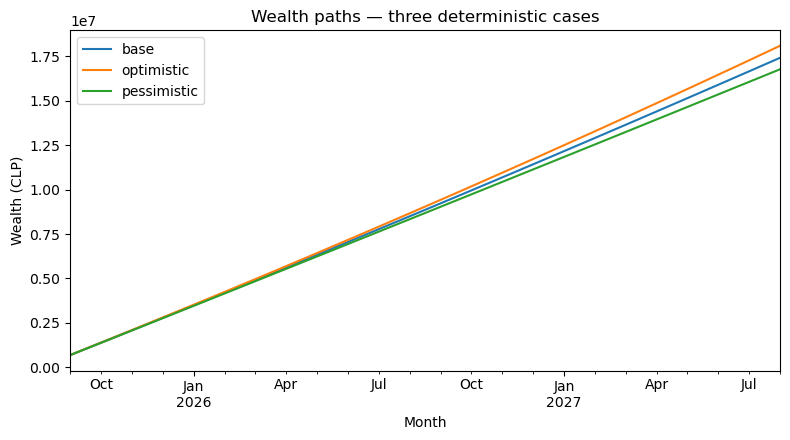

In [4]:

plt.figure(figsize=(8,4.5))
for name, res in res3.items():
    res.wealth.plot(label=name)
plt.title("Wealth paths — three deterministic cases")
plt.xlabel("Month")
plt.ylabel("Wealth (CLP)")
plt.legend()
plt.tight_layout()
plt.show()


## 3) Optimization — minimum constant contribution (closed-form)

In [5]:

T = 24
r = fixed_rate_path(T, 0.004)  # 0.4% monthly
B = 20_000_000.0               # target amount
W0 = 0.0                       # start wealth

mc_inp = MinContributionInput(target_amount=B, start_wealth=W0, returns_path=r)
mc_res = min_constant_contribution(mc_inp)
mc_res


MinContributionResult(a_star=795637.5168130582, annuity_factor=25.137075084280085, growth_W0=0.0, T=24)

In [6]:

# Verify by direct simulation
a_star = mc_res.a_star
wealth_check = simulate_capital(np.full(T, a_star), r, start_value=W0, index_like=contrib.index[:T])
float(wealth_check.iloc[-1]), B


(20080000.000000004, 20000000.0)

## 4) Optimization — minimum time given contribution (binary search)

In [7]:

a_fixed = float(contrib.iloc[0])  # use first-month contribution as a working monthly amount
r_long = fixed_rate_path(60, 0.004)  # allow up to 60 months
mt_inp = MinTimeInput(contribution=a_fixed, start_wealth=0.0, returns_path=r_long, success_threshold=6_000_000.0)
mt_res = min_time_given_contribution(mt_inp)
mt_res.T_hat


9

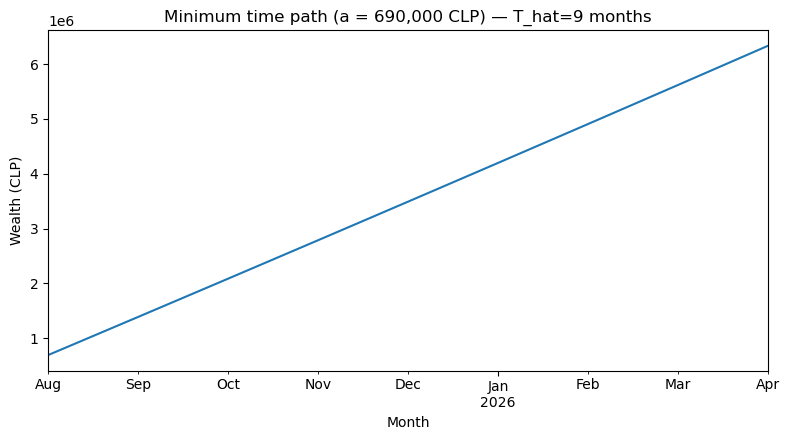

In [8]:

# Plot the found wealth path
plt.figure(figsize=(8,4.5))
mt_res.wealth_path.plot()
plt.title(f"Minimum time path (a = {a_fixed:,.0f} CLP) — T_hat={mt_res.T_hat} months")
plt.xlabel("Month")
plt.ylabel("Wealth (CLP)")
plt.tight_layout()
plt.show()


## 5) Goals & chance-constraints (Monte Carlo)

In [9]:

goals = [
    Goal(name="housing", target_amount=20_000_000.0, target_month_index=23),
    Goal(name="emergency", target_amount=6_000_000.0, target_month_index=11),
]
cfg_mc = ScenarioConfig(
    months=months, start=start, alpha_fixed=alpha, beta_variable=beta,
    base_r=0.004, optimistic_r=0.007, pessimistic_r=0.001,
    mc_mu=0.004, mc_sigma=0.02, mc_paths=200, seed=42
)
cc_inp = ChanceConstraintsInput(goals=goals, income_model=income, scen_cfg=cfg_mc, mc_paths=200)
cc_res = chance_constraints(cc_inp)
cc_res.success_prob_by_goal, cc_res.summary


(housing      1.00
 emergency    0.01
 dtype: float64,
 {'joint_success': 0.01, 'paths': 200})

## 6) Bonus — multi-asset portfolio (constant weights)

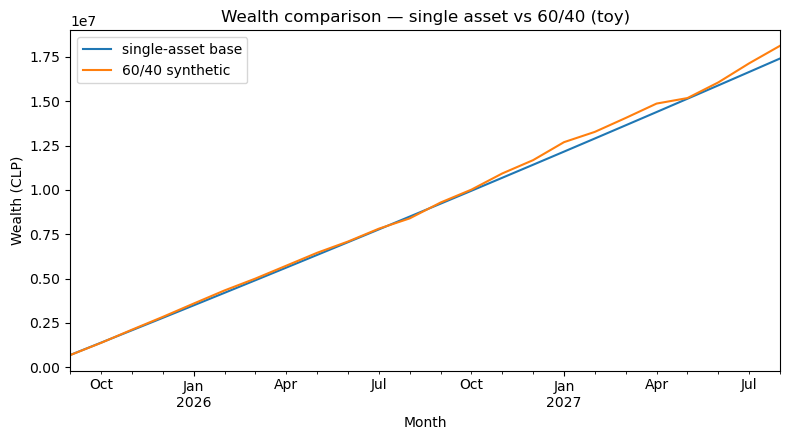

In [10]:

# Two synthetic assets for illustration
rng = np.random.default_rng(123)
T, N = months, 2
R = np.column_stack([
    rng.normal(0.006, 0.020, size=T),
    rng.normal(0.003, 0.010, size=T),
])
w = np.array([0.6, 0.4])
wealth_multi = simulate_portfolio(contrib.values, R, w, rebalance=True, index_like=contrib.index)

# Compare single-asset base case vs this 60/40 toy example
plt.figure(figsize=(8,4.5))
res3["base"].wealth.plot(label="single-asset base")
wealth_multi.plot(label="60/40 synthetic")
plt.title("Wealth comparison — single asset vs 60/40 (toy)")
plt.xlabel("Month")
plt.ylabel("Wealth (CLP)")
plt.legend()
plt.tight_layout()
plt.show()
